In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [33]:
# Custom normalization function
def custom_normalization(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image / 255.0
    image = (image - mean) / std
    return image

data_dir = r'D:\JupyterNote\002_Notebook\dataset_roti\train'
image_size = (224, 224)
batch_size = 32
num_folds = 5
num_epochs = 10

In [31]:
# Load filenames and labels
def load_dataset(directory):
    classes = sorted(os.listdir(directory))
    file_paths = []
    labels = []
    for label, class_dir in enumerate(classes):
        class_dir = os.path.join(directory, class_dir)
        for fname in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(str(label))  # Convert label to string
    return np.array(file_paths), np.array(labels), classes

# Load dataset
file_paths, labels, classes = load_dataset(data_dir)

In [32]:
fold_no = 1
for train_index, val_index in kf.split(file_paths):
    print(f'Fold {fold_no}')

    # Split dataset into train and validation sets
    train_files, val_files = file_paths[train_index], file_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Data generators
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        preprocessing_function=custom_normalization
    )

    val_datagen = ImageDataGenerator(preprocessing_function=custom_normalization)

    # Data generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Model MobileNetV3
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(classes), activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    test_loss, test_accuracy = model.evaluate(val_generator)
    print(f"Fold {fold_no} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    fold_no += 1

Fold 1
Found 284 validated image filenames belonging to 2 classes.


Found 72 validated image filenames belonging to 2 classes.
Epoch 1/10


d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4903 - loss: 4.7027 - val_accuracy: 0.6528 - val_loss: 4.1193 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 780ms/step - accuracy: 0.5853 - loss: 4.0572 - val_accuracy: 0.6806 - val_loss: 3.5503 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step - accuracy: 0.7031 - loss: 3.4746 - val_accuracy: 0.7361 - val_loss: 3.0891 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.6898 - loss: 3.0478 - val_accuracy: 0.7500 - val_loss: 2.7209 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.7601 - loss: 2.6801 - val_accuracy: 0.8194 - val_loss: 2.3890 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.7265 - loss: 2.3660 - val_accuracy: 0.7917 - val_loss: 2.1095 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.7485 - loss: 2.0469

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5493 - loss: 4.6340 - val_accuracy: 0.6620 - val_loss: 4.0776 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 769ms/step - accuracy: 0.6713 - loss: 3.9841 - val_accuracy: 0.7606 - val_loss: 3.4916 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 779ms/step - accuracy: 0.6802 - loss: 3.4412 - val_accuracy: 0.7324 - val_loss: 3.0367 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 798ms/step - accuracy: 0.6964 - loss: 2.9871 - val_accuracy: 0.7465 - val_loss: 2.6511 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step - accuracy: 0.7273 - loss: 2.6009 - val_accuracy: 0.7042 - val_loss: 2.3393 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 781ms/step - accuracy: 0.7035 - loss: 2.3504 - val_accuracy: 0.7042 - val_loss: 2.0699 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step - accuracy: 0.7424 - loss: 2.0197

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5339 - loss: 4.7117 - val_accuracy: 0.5775 - val_loss: 4.1374 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - accuracy: 0.6884 - loss: 4.0361 - val_accuracy: 0.7465 - val_loss: 3.5436 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.6377 - loss: 3.5569 - val_accuracy: 0.7746 - val_loss: 3.0846 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 760ms/step - accuracy: 0.6902 - loss: 3.0631 - val_accuracy: 0.7887 - val_loss: 2.7139 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 760ms/step - accuracy: 0.7708 - loss: 2.6359 - val_accuracy: 0.7887 - val_loss: 2.3903 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 0.7732 - loss: 2.3340 - val_accuracy: 0.7746 - val_loss: 2.1031 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 739ms/step - accuracy: 0.7752 - loss: 2.0419

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5258 - loss: 4.7139 - val_accuracy: 0.7324 - val_loss: 4.1081 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - accuracy: 0.5533 - loss: 4.0830 - val_accuracy: 0.6620 - val_loss: 3.6015 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - accuracy: 0.6816 - loss: 3.4816 - val_accuracy: 0.7183 - val_loss: 3.0950 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 763ms/step - accuracy: 0.7015 - loss: 3.0483 - val_accuracy: 0.6901 - val_loss: 2.7419 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 753ms/step - accuracy: 0.6977 - loss: 2.7148 - val_accuracy: 0.7324 - val_loss: 2.3910 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 769ms/step - accuracy: 0.7642 - loss: 2.3369 - val_accuracy: 0.7183 - val_loss: 2.1280 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 766ms/step - accuracy: 0.7593 - loss: 2.0745

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6568 - loss: 4.6016 - val_accuracy: 0.7183 - val_loss: 4.0812 - learning_rate: 5.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.5948 - loss: 4.0555 - val_accuracy: 0.7465 - val_loss: 3.5289 - learning_rate: 5.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 766ms/step - accuracy: 0.6704 - loss: 3.4500 - val_accuracy: 0.7606 - val_loss: 3.0550 - learning_rate: 5.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 761ms/step - accuracy: 0.6912 - loss: 3.0439 - val_accuracy: 0.7465 - val_loss: 2.6750 - learning_rate: 5.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 763ms/step - accuracy: 0.6918 - loss: 2.6201 - val_accuracy: 0.7465 - val_loss: 2.3707 - learning_rate: 5.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 0.7570 - loss: 2.2478 - val_accuracy: 0.7606 - val_loss: 2.0734 - learning_rate: 5.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.7791 - loss: 2.0005

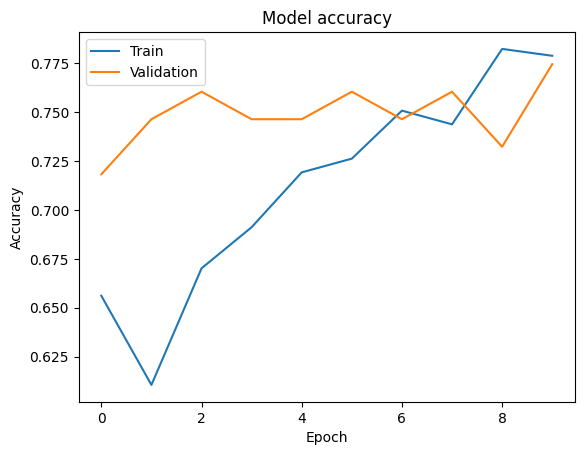

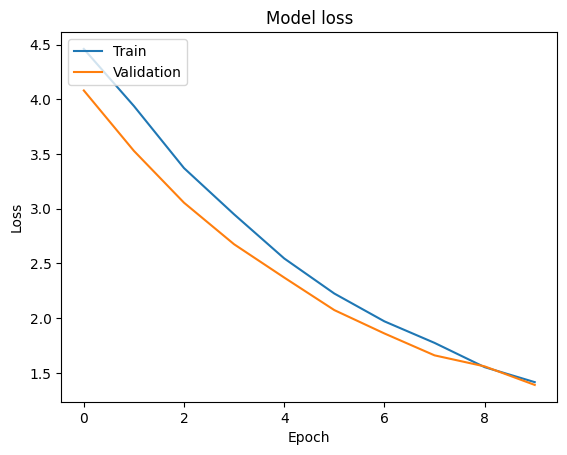

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
